# **Diamond Pricing Analysis & Prediction**

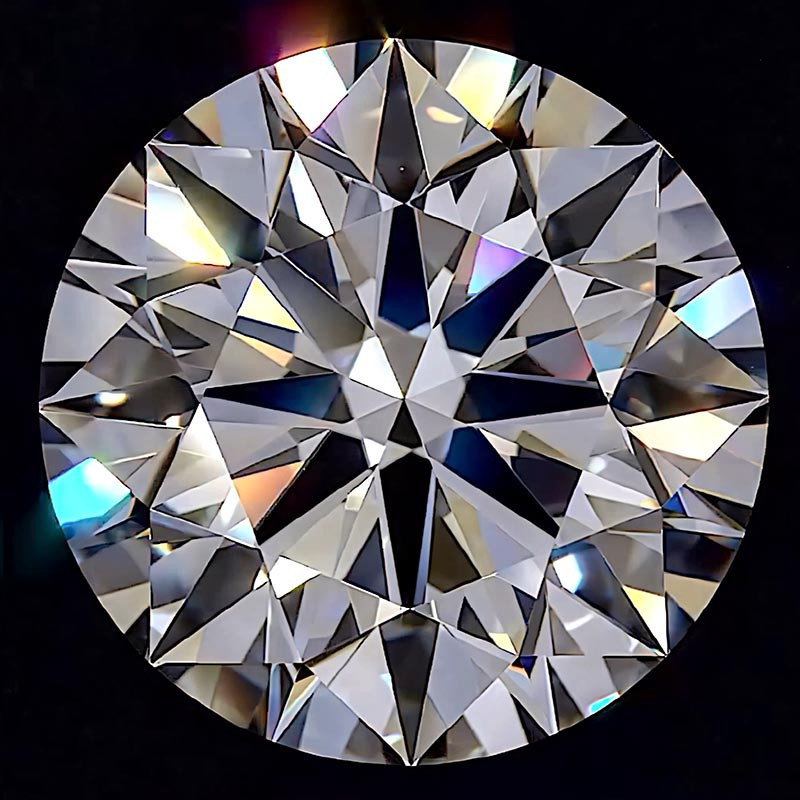

This notebook presents a full machine learning pipeline for predictive modeling using the Kaggle Diamonds dataset (diamonds.csv, sourced via https://www.kaggle.com/), which contains over 50,000 observations of diamond characteristics and sale prices. The primary objective is to build high-quality regression models capable of accurately estimating diamond prices based on physical attributes, such as carat, cut, color, and clarity, as well as dimensional measurements.


---


## This project aims to:
- Perform EDA to understand feature distributions and relationships.
- Clean and preprocess the dataset, including duplicate removal, outlier handling, feature scaling, and categorical encoding.
- Train and compare a variety of models using **scikit-learn** and **TensorFlow/Keras**, including deep neural networks.
- Evaluate models using **RMSE, MAE, MAPE**, & **R-Squared**, as well as learning curves and error diagnostics.


### Imports & Tools

In [74]:
import os

import joblib
import math
import kagglehub
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, QuantileTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats

import tensorflow as tf
from tensorflow import keras
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [30]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna()
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.1f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [31]:
def load_data(path: str) -> pd.DataFrame:
  if not os.path.exists(path):
    raise FileNotFoundError()
  df = pd.read_csv(path)
  print(f'Loaded initial dataset with shape {df.shape}')
  return df

In [32]:
DATA_PATH = "diamonds.csv"
TARGET_COL = "price"
MODEL_PATH = "diamond_pricing_model.joblib"
TEST_SIZE = 0.2
RANDOM_STATE = 42
MIN_COUNT = 100

## EDA & Data Preparation (Cleansing, Scaling, Normalization, Splitting, etc.)


In [33]:
df_raw = load_data(DATA_PATH)
df_raw.info()
df_raw.describe().T

Loaded initial dataset with shape (53940, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   x        53940 non-null  float64
 7   y        53940 non-null  float64
 8   z        53940 non-null  float64
 9   price    53940 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


,count,mean,std,min,25%,50%,75%,max
carat,53940.0,0.797940,0.474011,0.2,0.40,0.70,1.04,5.01
depth,53940.0,61.749405,1.432621,43.0,61.00,61.80,62.50,79.00
table,53940.0,57.457184,2.234491,43.0,56.00,57.00,59.00,95.00
x,53940.0,5.731157,1.121761,0.0,4.71,5.70,6.54,10.74
y,53940.0,5.734526,1.142135,0.0,4.72,5.71,6.54,58.90
z,53940.0,3.538734,0.705699,0.0,2.91,3.53,4.04,31.80
price,53940.0,3932.799722,3989.439738,326.0,950.00,2401.00,5324.25,18823.00


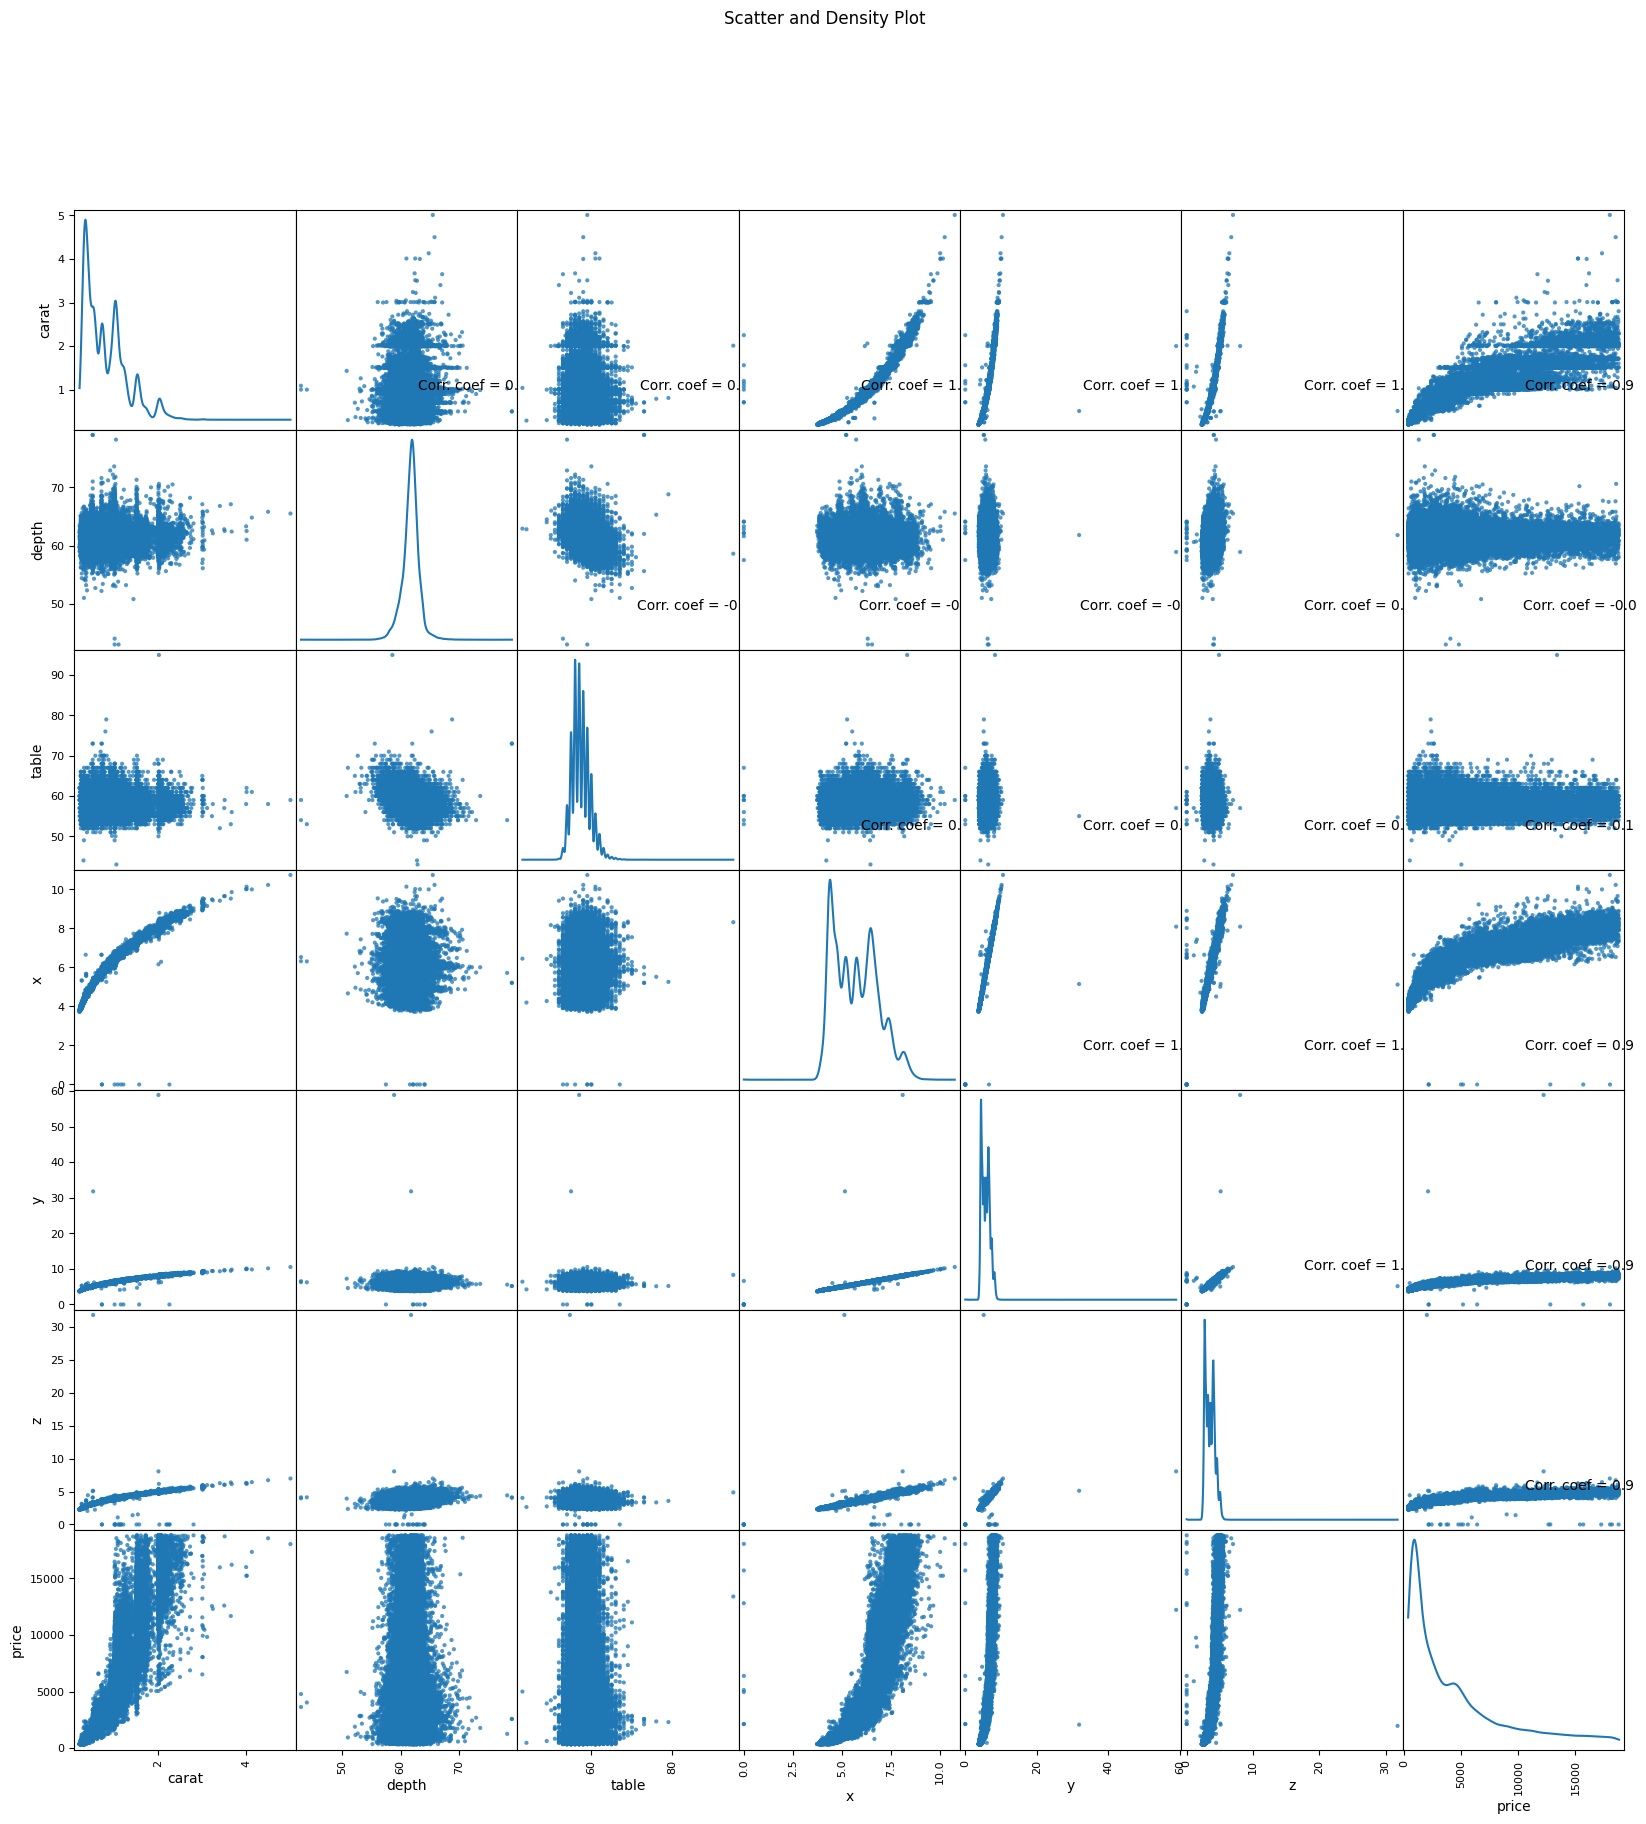

In [34]:
plotScatterMatrix(df_raw, 20, 10)

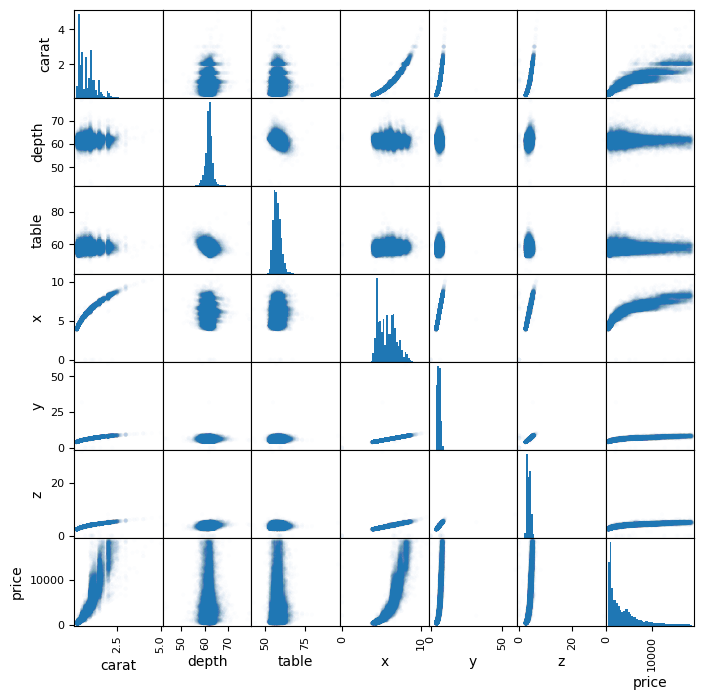

In [77]:
pd.plotting.scatter_matrix(df_raw,alpha=0.01,figsize=(8,8), hist_kwds={"bins": 50})
plt.show()

In [50]:
cols_to_check = ["x", "y", "z", "table"]
df_clean = df_raw[(df_raw[cols_to_check] > 0).all(axis=1)].reset_index(drop=True)

print("Original shape:", df_raw.shape)
print("After removing zero-value rows:", df_clean.shape)

Original shape: (53940, 10)
After removing zero-value rows: (53920, 10)


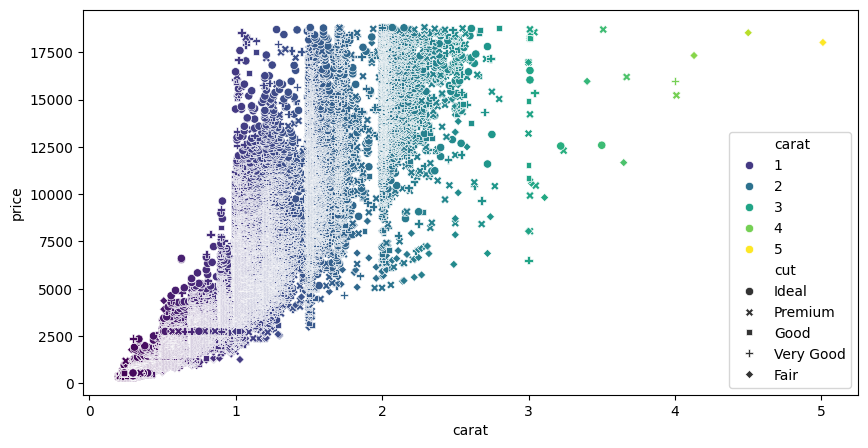

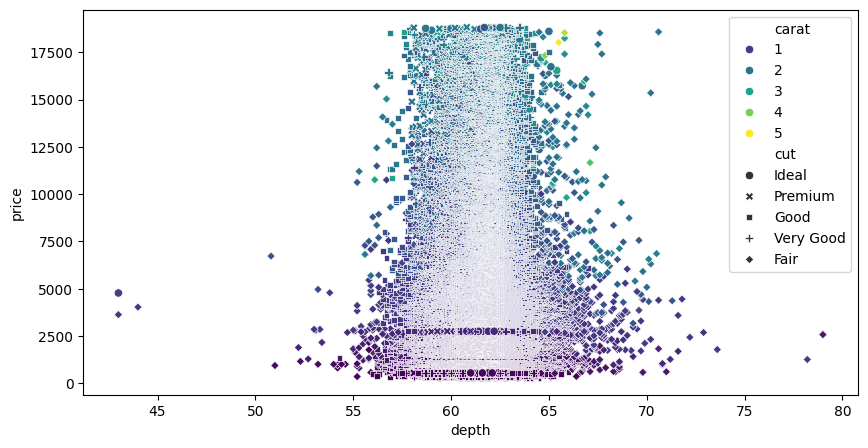

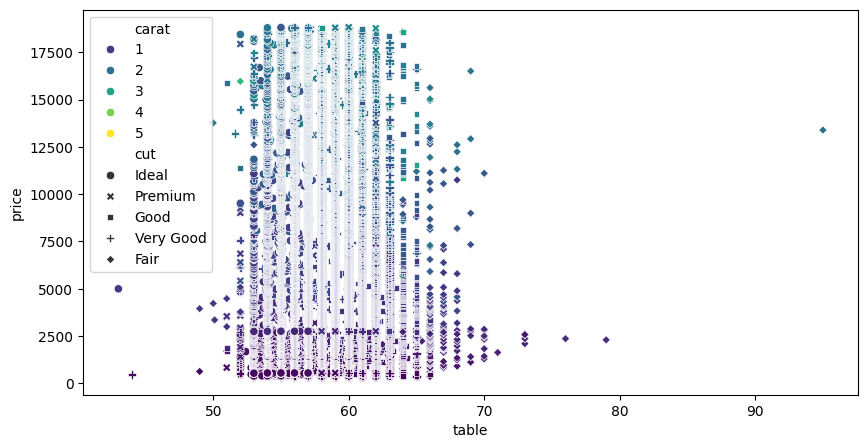

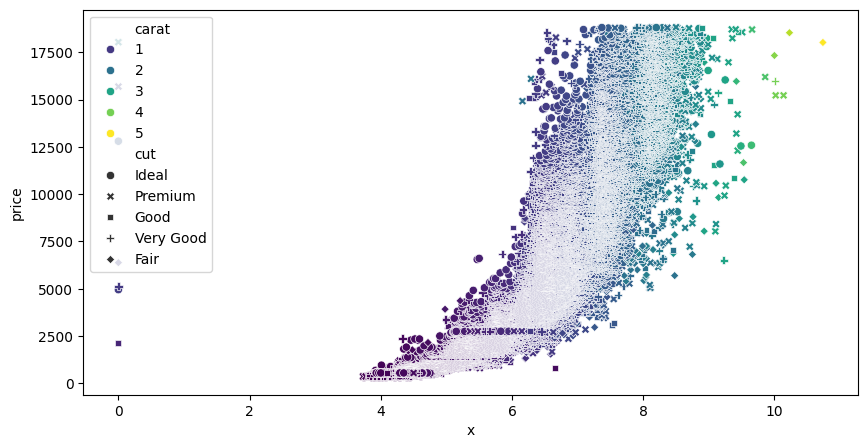

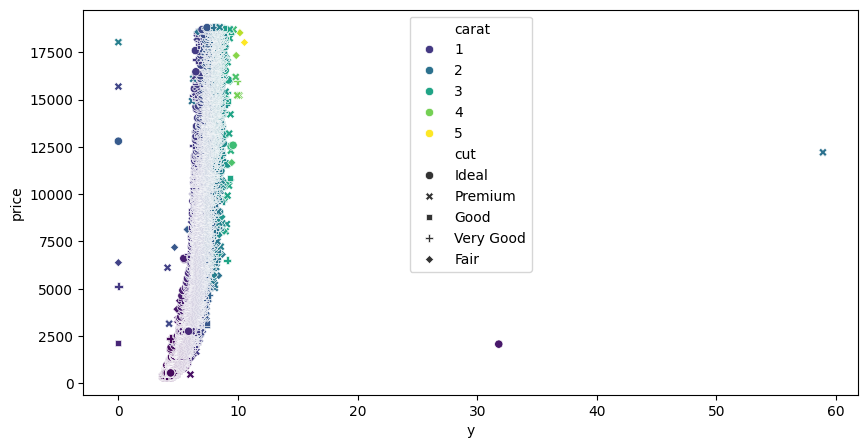

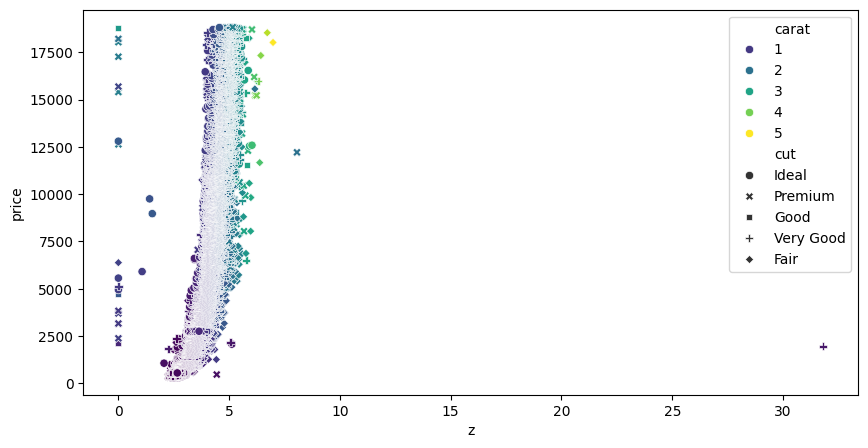

In [65]:
for col in df_raw.drop(TARGET_COL,axis=1).select_dtypes(include=np.number).columns:
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=df_raw, x=df_raw[col], y=TARGET_COL, hue="carat", style="cut", palette="viridis")

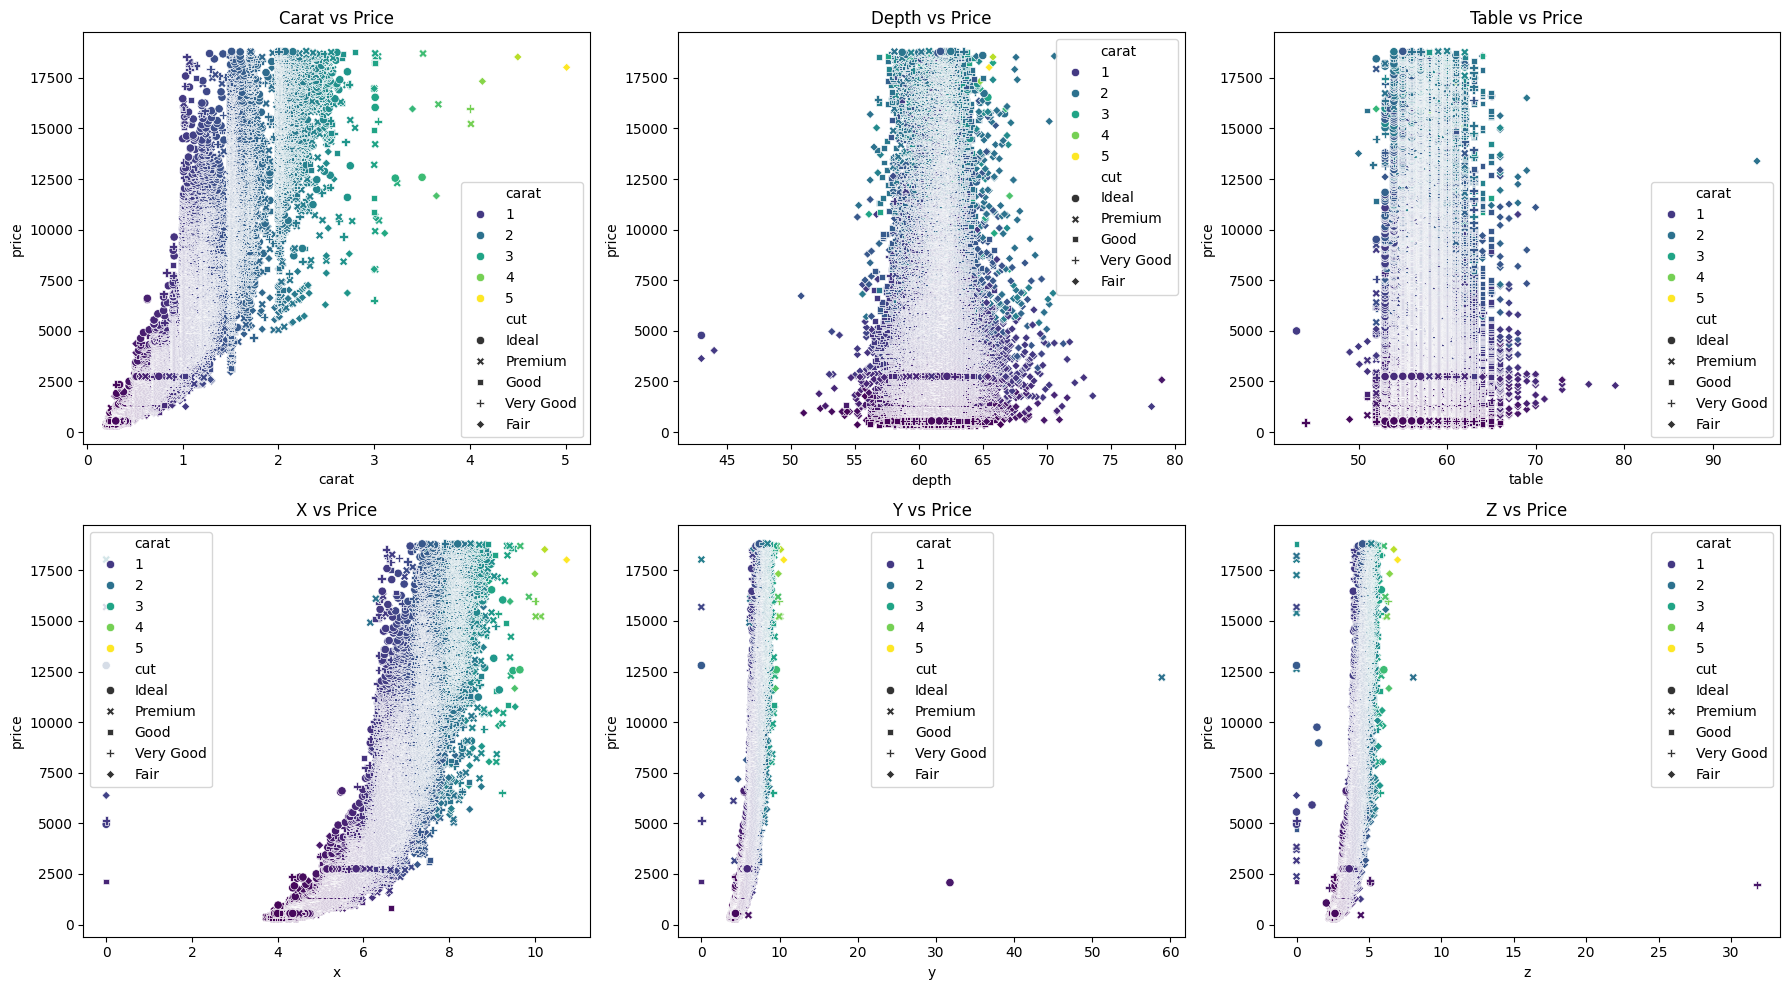

In [73]:
num_cols = df_raw.drop(TARGET_COL, axis=1).select_dtypes(include=np.number).columns

n_cols = 3
n_rows = math.ceil(len(num_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, num_cols):
    sns.scatterplot(
        data=df_raw,
        x=col,
        y=TARGET_COL,
        hue="carat",
        style="cut",
        palette="viridis",
        ax=ax
    )
    ax.set_title(f"{col.capitalize()} vs {TARGET_COL.capitalize()}", fontsize=12)

# Hide any unused subplot panels
for j in range(len(num_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [37]:
duplicates = df_raw[df_raw.duplicated()]
print(f' Number of duplicates: {len(duplicates)}')
duplicates.info()
duplicate_indices = df_raw.index[df_raw.duplicated()].tolist()
check = (duplicate_indices == duplicates.index.tolist())
print(check)

 Number of duplicates: 146
<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, 1005 to 52861
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    146 non-null    float64
 1   cut      146 non-null    object 
 2   color    146 non-null    object 
 3   clarity  146 non-null    object 
 4   depth    146 non-null    float64
 5   table    146 non-null    float64
 6   x        146 non-null    float64
 7   y        146 non-null    float64
 8   z        146 non-null    float64
 9   price    146 non-null    int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 12.5+ KB
True


In [38]:
df_nodups = df_raw.drop_duplicates(keep="first").reset_index(drop=True)
df_nodups_noprice_numeric = df_nodups.drop(TARGET_COL, axis=1).select_dtypes(include=np.number)

print("Shape before removing duplicates:", df_raw.shape)
print("Shape after removing duplicates:", df_nodups.shape)
unique_counts_df = df_nodups.nunique()
print(unique_counts_df)
total_val_counts = df_nodups.nunique().sum()
print(f'Total unique counts: {total_val_counts}')

Shape before removing duplicates: (53940, 10)
Shape after removing duplicates: (53794, 10)
carat        273
cut            5
color          7
clarity        8
depth        184
table        127
x            554
y            552
z            375
price      11602
dtype: int64
Total unique counts: 13687


In [39]:
vc_dfs = []

for col in df_nodups_noprice_numeric.columns:
    # get val counts for current col
    vc = df_nodups[col].value_counts()

    # add value counts to two-col DF of the form [value, count]
    vc = vc.reset_index()
    vc.columns = [f'{col}_value', f'{col}_count']

    vc_dfs.append(vc)

# concatenate all two-col frames into value_count table
vc_table = pd.concat(vc_dfs, axis=1).fillna("")
print(vc_table)

    carat_value carat_count depth_value depth_count table_value table_count  \
0           0.3      2596.0        62.0      2233.0        56.0      9851.0   
1          1.01      2240.0        61.9      2160.0        57.0      9695.0   
2          0.31      2238.0        61.8      2069.0        58.0      8352.0   
3           0.7      1981.0        62.2      2033.0        59.0      6562.0   
4          0.32      1827.0        62.1      2011.0        55.0      6242.0   
..          ...         ...         ...         ...         ...         ...   
549                                                                           
550                                                                           
551                                                                           
552                                                                           
553                                                                           

     x_value  x_count y_value y_count z_value z_cou

In [41]:
type(vc_dfs)

list

In [ ]:
sns.pairplot(
    data=df_nodups,
    x_vars=df_nodups_noprice_numeric.columns.tolist(),
    y_vars=[TARGET_COL],
    height=3
)

The pairplots show that it might be useful to consider a polynomial feature characteristic for the 'carat', 'x', 'y', and 'z' features. This will be done later with the PolyFeat() object.

In [ ]:
for col in df_nodups_noprice_numeric.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_raw[col], kde=True, bins=50, color='darkred')
    plt.title(f"Seaborn Distribution for {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

In [ ]:
for col in df_nodups.drop(['price'], axis=1).select_dtypes(['float64', 'int64']).columns:
    print(f'Skewness for {col}: {df_nodups[col].skew()}')

In [ ]:
for col in ['carat', 'table', 'depth']:
    print(f'Log-transformed skewness for {col}: {np.log(df_nodups[col]).skew()}')

In [ ]:
for col in ['carat', 'table', 'depth']:
    clean = df_nodups[col]
    box, lam = stats.boxcox(clean)
    print(col, "skew:", pd.Series(box).skew(), "lambda:", lam)

In [ ]:
plt.figure(figsize=(14, 6))

for i, col in enumerate(['carat', 'table', 'depth']):
    # Extract and clean data
    clean = df_nodups[col][df_nodups[col] > 0]

    # Apply Box–Cox
    transformed, lam = stats.boxcox(clean)

    # Plot histogram
    plt.subplot(1, 3, i+1)
    plt.hist(transformed, bins=50, edgecolor='black')
    plt.title(f"Histogram of Box–Cox Transformed {col}\n(lambda = {lam:.4f})")
    plt.xlabel(f"Transformed {col}")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(14, 6))

for i, col in enumerate(df_nodups_noprice_numeric.columns):
    # Extract and clean data
    clean = df_nodups[col][df_nodups[col] > 0]

    # Apply Box–Cox
    transformed, lam = stats.boxcox(clean)

    # Plot histogram
    plt.subplot(1, 6, i+1)
    plt.hist(transformed, bins=50, edgecolor='black')
    plt.title(f"Histogram of Box–Cox Transformed {col}\n(lambda = {lam:.4f})")
    plt.xlabel(f"Transformed {col}")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
cols = ['carat', 'table', 'depth']

# Prepare a list to store results for FacetGrid
plot_data = []

for col in cols:
    clean = df_nodups.loc[df_nodups[col] > 0, col]

    # Box–Cox transform
    transformed, lam = stats.boxcox(clean)

    # Store in a DataFrame for seaborn
    plot_data.append(
        pd.DataFrame({
            'value': transformed,
            'variable': col,
            'lambda': lam
        })
    )

# Combine into one long-format DataFrame
plot_df = pd.concat(plot_data, ignore_index=True)

# --- Seaborn plotting ---
g = sns.FacetGrid(plot_df, col="variable", sharex=False, sharey=False, height=4, aspect=1.2)

g.map_dataframe(sns.histplot, x="value", bins=50, edgecolor='black')

# Add per-panel titles with lambda values
for ax, (col, lam) in zip(g.axes.flat, [(d['variable'][0], d['lambda'][0]) for d in plot_data]):
    ax.set_title(f"Histogram of Box–Cox Transformed {col}\n(lambda = {lam:.4f})")
    ax.set_xlabel(f"Transformed {col}")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer, StandardScaler

# Transform
qt = QuantileTransformer(output_distribution="normal", random_state=0)
df_nodups['carat_gauss'] = qt.fit_transform(df_nodups[['carat']])

scaler = StandardScaler()
df_nodups['carat_gauss_scaled'] = scaler.fit_transform(df_nodups[['carat_gauss']])

# Plotting
plt.figure(figsize=(18, 5))

# 1. Original distribution
plt.subplot(1, 3, 1)
plt.hist(df_nodups['carat'], bins=50, edgecolor='black')
plt.title("Original Carat Distribution")
plt.xlabel("carat")
plt.ylabel("Frequency")

# 2. Quantile → Normal distribution
plt.subplot(1, 3, 2)
plt.hist(df_nodups['carat_gauss'], bins=50, edgecolor='black')
plt.title("Gaussianized (Quantile Transform)")
plt.xlabel("carat_gauss")
plt.ylabel("Frequency")

# 3. Gaussianized + Standard Scaled
plt.subplot(1, 3, 3)
plt.hist(df_nodups['carat_gauss_scaled'], bins=50, edgecolor='black')
plt.title("Gaussianized + StandardScaler")
plt.xlabel("carat_gauss_scaled")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
print(f'Skewness for carat_gauss: {df_nodups["carat_gauss"].skew()}')
print(f'Skewness for carat_gauss_scaled: {df_nodups["carat_gauss_scaled"].skew()}')
check2 = (df_nodups["carat_gauss"].skew() < df_nodups["carat_gauss_scaled"].skew())
print(check2)

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_nodups_noprice_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap — Predictors Only (X)")
plt.show()

In [ ]:
numeric_cols = df_raw.select_dtypes(include=np.number).columns
n = len(numeric_cols)

plt.figure(figsize=(15, 4 * ((n + 2) // 3)))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot((n + 2) // 3, 3, i)
    sns.boxplot(x=df_raw[col], color='orange')
    plt.title(col)

plt.tight_layout()
plt.show()

In [ ]:
X = df_raw.drop(TARGET_COL, axis=1)
y = df_raw[TARGET_COL]

In [ ]:
X = df_nodups.drop(TARGET_COL, axis=1)
y = df_nodups[TARGET_COL].dropna()

X = X.dropna()
X.info()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,      # you already defined TEST_SIZE = 0.2
    random_state=RANDOM_STATE # and RANDOM_STATE = 42
)

# Identify numeric / categorical columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.columns.difference(numeric_features)

print("Numeric features:", list(numeric_features))
print("Categorical features:", list(categorical_features))

# Preprocessor: Standardize numeric features + OneHotEncode categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ]
)

In [ ]:
sklearn_models = {
    "LinearRegression": LinearRegression(),
    "Ridge(alpha=10)": Ridge(alpha=10.0),
    "RandomForest(200, depth=10)": RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
}

sklearn_results = []

for name, reg in sklearn_models.items():
    print(f"\nTraining sklearn model: {name}")
    pipe = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', reg),
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae  = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    sklearn_results.append({
        "model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
    })

sklearn_results_df = pd.DataFrame(sklearn_results).sort_values("R2", ascending=False)
print("\nSklearn model comparison:")
print(sklearn_results_df)

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=sklearn_results_df,
    x="model",
    y="R2"
)
plt.title("Sklearn Models – R² on Test Set")
plt.ylim(0, 1)
plt.ylabel("R²")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

input_dim = X_train_proc.shape[1]
print("Preprocessed input dimension:", input_dim)

In [ ]:
def build_dnn(input_dim, activation="relu", n_hidden=2, units=64, dropout_rate=0.0):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(shape=(input_dim,)))
    for _ in range(n_hidden):
        model.add(keras.layers.Dense(units, activation=activation))
        if dropout_rate > 0:
            model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(1))  # regression output

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model

In [ ]:
tf_configs = [
    ("DNN_relu_2x64",  dict(activation="relu", n_hidden=2, units=64,  dropout_rate=0.0)),
    ("DNN_relu_3x128", dict(activation="relu", n_hidden=3, units=128, dropout_rate=0.1)),
    ("DNN_tanh_3x64",  dict(activation="tanh", n_hidden=3, units=64,  dropout_rate=0.0)),
]

histories = {}
tf_results = []

EPOCHS = 30
BATCH_SIZE = 256

for name, cfg in tf_configs:
    print(f"\nTraining TensorFlow model: {name} with config: {cfg}")
    model = build_dnn(input_dim, **cfg)

    history = model.fit(
        X_train_proc,
        y_train,
        validation_split=0.2,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0,
    )
    histories[name] = history

    # Evaluate on test set
    test_loss, test_mae = model.evaluate(X_test_proc, y_test, verbose=0)
    tf_results.append({
        "model": name,
        "Test_MSE": test_loss,
        "Test_MAE": test_mae,
    })

tf_results_df = pd.DataFrame(tf_results).sort_values("Test_MAE")
print("\nTensorFlow model comparison (sorted by Test_MAE):")
print(tf_results_df)

In [ ]:
plt.figure(figsize=(12, 5))
for name, history in histories.items():
    plt.plot(history.history["val_mae"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Validation MAE")
plt.title("TensorFlow Models – Validation MAE per Epoch")
plt.legend()
plt.tight_layout()
plt.show()

# Validation MSE (loss) curves
plt.figure(figsize=(12, 5))
for name, history in histories.items():
    plt.plot(history.history["val_loss"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Validation MSE (loss)")
plt.title("TensorFlow Models – Validation Loss per Epoch")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
combined_mae = []

for row in sklearn_results:
    combined_mae.append({
        "model": row["model"],
        "framework": "sklearn",
        "MAE": row["MAE"],
    })

for row in tf_results:
    combined_mae.append({
        "model": row["model"],
        "framework": "tensorflow",
        "MAE": row["Test_MAE"],
    })

combined_df = pd.DataFrame(combined_mae).sort_values("MAE")
print("\nCombined MAE comparison:")
print(combined_df)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=combined_df,
    x="model",
    y="MAE",
    hue="framework"
)
plt.title("Sklearn vs TensorFlow – Test MAE Comparison")
plt.ylabel("MAE (lower is better)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
best_name = "DNN_relu_3x128"
best_cfg = dict(activation="relu", n_hidden=3, units=128, dropout_rate=0.1)

EPOCHS_BEST = 80
BATCH_SIZE_BEST = 256

best_model = build_dnn(input_dim, **best_cfg)

history_best = best_model.fit(
    X_train_proc,
    y_train,
    validation_split=0.2,
    epochs=EPOCHS_BEST,
    batch_size=BATCH_SIZE_BEST,
    verbose=0,
)

test_mse, test_mae = best_model.evaluate(X_test_proc, y_test, verbose=0)
print(f"{best_name} – Test MSE: {test_mse:.2f}, Test MAE: {test_mae:.2f}")

In [ ]:
y_pred_test = best_model.predict(X_test_proc).reshape(-1)
y_true_test = y_test.to_numpy()

# Classic regression metrics
mse  = mean_squared_error(y_true_test, y_pred_test)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true_test, y_pred_test)
r2   = r2_score(y_true_test, y_pred_test)

print(f"\n[{best_name}] Regression metrics on test set:")
print(f"  MSE : {mse:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  MAE : {mae:.2f}")
print(f"  R^2 : {r2:.4f}")

In [ ]:
eps = 1e-8  # to avoid division by zero
abs_error = np.abs(y_pred_test - y_true_test)
rel_error = abs_error / (np.abs(y_true_test) + eps)  # relative error

for thr in [0.05, 0.10, 0.20]:  # 5%, 10%, 20%
    acc = np.mean(rel_error <= thr)
    print(f"Fraction of test points within {int(thr*100)}% of true price: {acc*100:.2f}%")